### Preprocessing Data

In [18]:
import pandas as pd
import geopandas as gpd
import shapely

filename_streets = 'data_unwrangled/Centerline.csv'
filename_collisions = 'data_unwrangled/Motor_Vehicle_Collisions_-_Crashes.csv'

In [5]:
df_streets = pd.read_csv(filename_streets)
gdf_streets = gpd.GeoDataFrame(df_streets)
gdf_streets['the_geom'] = gdf_streets['the_geom'].apply(shapely.wkt.loads)
gdf_streets.set_geometry('the_geom', inplace=True)

/var/folders/0n/hqwrwrp96x3g_q8dnhlmvghh0000gn/T/ipykernel_9513/1982068825.py:3: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_streets = pd.read_csv(data_street)


In [6]:
# Hand chosen lower manhattan polygon because of high citibike density
points_lat = [40.72702, 40.73375, 40.73336, 40.71464, 40.71505]
points_long = [-73.97238, -73.98580, -73.99969, -74.01390, -73.97978]
filter = shapely.geometry.Polygon(zip(points_long, points_lat))
filter = gpd.GeoDataFrame(geometry = [filter])

In [7]:
gdf_restricted = gdf_streets.sjoin(filter) # restrict streets to filter

<AxesSubplot:>

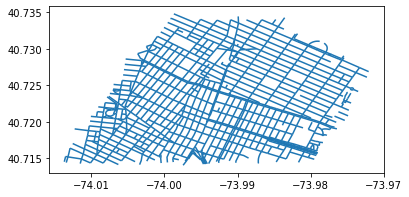

In [8]:
gdf_restricted.plot()

In [16]:
def get_neighbors(geometry, id):
    neighbors = gdf_restricted['PHYSICALID'].loc[gdf_restricted['the_geom'].intersects(geometry)].tolist()
    neighbors.remove(id)
    return neighbors

# Build column with adjacent links
# WARNING: Can only do on restricted data, otherwise it will take forever
gdf_restricted['neighbors'] = gdf_restricted.apply(lambda x: get_neighbors(x.the_geom, x.PHYSICALID), axis=1)

In [92]:
df_collisions = pd.read_csv(filename_collisions).dropna(subset=['LATITUDE', 'LONGITUDE'])

/var/folders/0n/hqwrwrp96x3g_q8dnhlmvghh0000gn/T/ipykernel_9513/755595590.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_collisions = pd.read_csv(filename_collisions).dropna(subset=['LATITUDE', 'LONGITUDE'])


In [93]:
mask = df_collisions['BOROUGH'].str.contains('bike') # placeholder
for i in [1,2,3,4,5]:
    mask = mask | df_collisions[f'VEHICLE TYPE CODE {i}'].str.contains('bike', case=False)

# Restrict to collisions involving bikes
df_restricted = df_collisions.loc[mask]

In [95]:
start_date = pd.Timestamp('2018-01-01')
end_date = pd.Timestamp('2019-01-01')
df_restricted['CRASH DATE'] = pd.to_datetime(df_restricted['CRASH DATE'])
mask = (df_restricted['CRASH DATE'] > start_date) & (df_restricted['CRASH DATE'] <= end_date)

# Restrict to within time range
df_restricted = df_restricted.loc[mask]

/var/folders/0n/hqwrwrp96x3g_q8dnhlmvghh0000gn/T/ipykernel_9513/1088248514.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted['CRASH DATE'] = pd.to_datetime(df_restricted['CRASH DATE'])


In [96]:
df_restricted

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
503997,2018-12-18,18:35,MANHATTAN,10022.0,40.758373,-73.971000,"(40.758373, -73.971)",LEXINGTON AVENUE,EAST 53 STREET,NaN,...,Unspecified,NaN,NaN,NaN,4048317,Bike,Bike,NaN,NaN,NaN
504104,2018-12-15,15:22,BRONX,10455.0,40.813610,-73.913345,"(40.81361, -73.913345)",EAST 148 STREET,SAINT ANNS AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4045468,Sedan,Bike,NaN,NaN,NaN
504147,2018-12-07,16:15,QUEENS,11103.0,40.770030,-73.912170,"(40.77003, -73.91217)",24 AVENUE,37 STREET,NaN,...,Unspecified,NaN,NaN,NaN,4041913,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
504338,2018-12-22,0:07,BRONX,10460.0,40.843014,-73.885200,"(40.843014, -73.8852)",NaN,NaN,1976 CROTONA PARKWAY,...,Other Vehicular,NaN,NaN,NaN,4053926,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
504413,2018-12-08,14:07,MANHATTAN,10024.0,40.786090,-73.972460,"(40.78609, -73.97246)",NaN,NaN,527 COLUMBUS AVENUE,...,Unspecified,NaN,NaN,NaN,4042517,Sedan,Bike,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735763,2018-01-02,10:00,NaN,NaN,40.588512,-73.949356,"(40.588512, -73.949356)",OCEAN AVENUE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,3821192,Sedan,Bike,NaN,NaN,NaN
735789,2018-01-15,16:00,BRONX,10472.0,40.827423,-73.868230,"(40.827423, -73.86823)",ROSEDALE AVENUE,WATSON AVENUE,NaN,...,Aggressive Driving/Road Rage,NaN,NaN,NaN,3828836,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
735861,2018-01-23,12:23,BROOKLYN,11220.0,40.638878,-74.006050,"(40.638878, -74.00605)",8 AVENUE,54 STREET,NaN,...,Unspecified,NaN,NaN,NaN,3834220,Bike,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
735902,2018-01-09,18:17,MANHATTAN,10010.0,40.738830,-73.983154,"(40.73883, -73.983154)",EAST 23 STREET,3 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,3831217,Bike,Bus,NaN,NaN,NaN
